## Model comparison script

In [1]:
import pandas as pd
import numpy as np
import s3fs
import pyarrow.parquet as pq

In [39]:
import os
import fastparquet
import random
import statistics
import traceback
import ast
from collections import Counter

In [3]:
s3 = s3fs.S3FileSystem()

In [4]:
contesting_models = ['roberta', 'scibert', 'deberta', 'biomed_roberta', 'cs_roberta']

In [5]:
# TODO: Make changes in this cell after cs_roberta
# Save the predictions_cs_roberta.parquet file to S3 dagpapsubmission

total_score = (0.87 + 0.88 + 0.89 + 0.89 + )
model_scores = {'roberta': 0.88, 'scibert': 0.87, 'deberta': 0.89, 'biomed_roberta': 0.89, , 'cs_roberta': }
model_weights = {"scibert": model_scores['scibert']/total_score,
                 "roberta": model_scores['roberta']/total_score,
                 "deberta": model_scores['deberta']/total_score,
                 "biomed_roberta": model_scores['biomed_roberta']/total_score,
                 "cs_roberta": model_scores['biomed_roberta']/total_score}

In [6]:
model_weights

{'scibert': 0.24645892351274787,
 'roberta': 0.24929178470254956,
 'deberta': 0.2521246458923513,
 'biomed_roberta': 0.2521246458923513}

In [7]:
# class_dict = {"human":0,"NLTK_synonym_replacement":1,"chatgpt":2,"summarized":3}
# class_labels_list = [0, 1, 2, 3]

In [127]:
def merge_model_predictions():
    dev_df = pq.ParquetDataset('s3://dagpapsubmission/data/data_dev_data.parquet', filesystem=s3).read_pandas().to_pandas()
    dev_df["tokens"] = dev_df.tokens.map(lambda x:ast.literal_eval(x.decode()))
    
    for model in contesting_models:
        model_df = pq.ParquetDataset(f's3://dagpapsubmission/predictions_{model}.parquet', filesystem=s3).read_pandas().to_pandas()
        model_df.rename(columns={'preds': f'{model}_preds'}, inplace=True)
        
        dev_df = dev_df.merge(model_df, how='inner', left_index=True, right_index=True)
        print(f"Data shape after merging with {model} model {dev_df.shape}")
    
    return dev_df

In [106]:
def get_max_repeated_pred(input_df):
    input_df['preds'] = None
    input_df['majority_model'] = 'baseline'
    input_df['majority_col'] = None
    for index, row in input_df.iterrows():
        combined_preds_max = [0] * len(row['tokens'])
        majority_model_prediction = ['baseline'] * len(row['tokens'])
        majority_col_val = [0] * len(row['tokens'])
    
        for i in range(len(row['tokens'])):
            preds_data = [row['roberta_preds'][i], row['scibert_preds'][i], row['deberta_preds'][i],
                              row['biomed_roberta_preds'][i], row['cs_roberta_preds'][i]]
            
            max_repeated = statistics.multimode(preds_data)
            if len(max_repeated) != 1:
                # Weighted avg
                combined_preds_max[i] = random.choices(
                    preds_data, weights=[model_weights['roberta'], model_weights['scibert'],
                                         model_weights['deberta'], model_weights['biomed_roberta'], 
                                         model_weights['cs_roberta']],
                    k=1)[0]
                if combined_preds_max[i] == row['deberta_preds'][i]:
                    majority_model_prediction[i] = 'deberta'
                elif combined_preds_max[i] == row['biomed_roberta_preds'][i]:
                    majority_model_prediction[i] = 'biomed_roberta'
                elif combined_preds_max[i] == row['roberta_preds'][i]:
                    majority_model_prediction[i] = 'roberta'
                elif combined_preds_max[i] == row['cs_roberta_preds'][i]:
                    majority_model_prediction[i] = 'cs_roberta'
                else:
                    majority_model_prediction[i] = 'scibert'
                majority_col_val[i] = 0
            else:
                combined_preds_max[i] = max_repeated[0]
                if (row['deberta_preds'][i] == row['biomed_roberta_preds'][i]) and \
                (row['roberta_preds'][i] == row['biomed_roberta_preds'][i]) and \
                (row['roberta_preds'][i] == row['scibert_preds'][i]) and \
                (row['deberta_preds'][i] == row['scibert_preds'][i]) and \
                (row['cs_roberta_preds'][i] == row['scibert_preds'][i]):
                    majority_model_prediction[i] = 'all'
                else:
                    majority_model_prediction[i] = 'majority'
                majority_col_val[i] = 1
                    
        input_df.at[index,'preds'] = combined_preds_max
        input_df.at[index, 'majority_model'] = majority_model_prediction
        input_df.at[index, 'majority_col'] = majority_col_val
        
    return input_df

### Function calls to make the predictions and save the parquet file

In [32]:
%%time
merged_model_dev_predictions = merge_model_predictions()

Data shape after merging with roberta model (5000, 3)
Data shape after merging with scibert model (5000, 4)
Data shape after merging with deberta model (5000, 5)
Data shape after merging with biomed_roberta model (5000, 6)
CPU times: user 2min 31s, sys: 2.33 s, total: 2min 34s
Wall time: 2min 37s


In [107]:
%%time
majority_vote_df = get_max_repeated_pred(merged_model_dev_predictions)
majority_vote_df.head()

CPU times: user 13min 5s, sys: 801 ms, total: 13min 6s
Wall time: 13min 6s


,text,tokens,roberta_preds,scibert_preds,deberta_preds,biomed_roberta_preds,preds,majority_model,stats,majority_col
index,,,,,,,,,,
12313,Phylogenetic networks are a generalization of ...,"[Phylogenetic, networks, are, a, generalizatio...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[all, all, all, all, all, all, all, all, all, ...","{'all': 5730, 'biomed_roberta': 17, 'deberta':...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3172,Prediction modelling is more closely aligned w...,"[Prediction, modelling, is, more, closely, ali...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[all, all, all, all, all, all, all, all, all, ...","{'all': 4201, 'deberta': 112, 'biomed_roberta'...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6451,The heat transfer exhibits the flow of heat (t...,"[The, heat, transfer, exhibits, the, flow, of,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[all, all, all, all, all, all, all, all, all, ...","{'all': 4256, 'deberta': 111, 'biomed_roberta'...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4351,a common experience during superficial ultraso...,"[a, common, experience, during, superficial, u...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[all, deberta, deberta, deberta, deberta, debe...","{'all': 2794, 'deberta': 31, 'biomed_roberta':...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
22694,Code metadata Current code version v1.5.9 Perm...,"[Code, metadata, Current, code, version, v1.5....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[all, all, all, all, all, all, all, all, all, ...",{'all': 5373},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [ ]:
majority_vote_df[['preds']].to_parquet('predictions_four_models.parquet')

# End here

### Finding the stats about the majority column

In [ ]:
def get_model_stats(row):
    stats_dict = row['stats']
    out_dict = {}
    out_keys =  ['roberta', 'scibert', 'deberta', 'biomed_roberta',  'all']
    out_dict = {key:stats_dict[key] if key in list(stats_dict.keys()) else 0 for key in out_keys}
    
    return out_dict

In [108]:
majority_vote_df['stats'] = majority_vote_df[['majority_model']].map(lambda x: Counter(x))
# majority_vote_df.head()

In [114]:
stats_df = majority_vote_df[['tokens', 'stats', 'majority_col']]
stats_df.head()

,tokens,stats,majority_col
index,,,
12313,"[Phylogenetic, networks, are, a, generalizatio...","{'all': 5730, 'biomed_roberta': 14, 'deberta':...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3172,"[Prediction, modelling, is, more, closely, ali...","{'all': 4201, 'deberta': 108, 'biomed_roberta'...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
6451,"[The, heat, transfer, exhibits, the, flow, of,...","{'all': 4256, 'deberta': 113, 'biomed_roberta'...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4351,"[a, common, experience, during, superficial, u...","{'all': 2794, 'deberta': 34, 'biomed_roberta':...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
22694,"[Code, metadata, Current, code, version, v1.5....",{'all': 5373},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


In [115]:
stats_df['len_tokens'] = stats_df['tokens'].map(lambda x : len(x))
stats_df.drop(columns=['tokens'], inplace=True)

/tmp/ipykernel_28007/637037902.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['len_tokens'] = stats_df['tokens'].map(lambda x : len(x))
/tmp/ipykernel_28007/637037902.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df.drop(columns=['tokens'], inplace=True)


In [117]:
stats_df['sum_majority'] = stats_df['majority_col'].map(lambda x : sum(x))

/tmp/ipykernel_28007/2158198887.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['sum_majority'] = stats_df['majority_col'].map(lambda x : sum(x))


In [132]:
stats_df['sum_majority_not_all'] = stats_df['sum_majority'] - stats_df['all']
stats_df.head()

,stats,majority_col,len_tokens,sum_majority,pct_majority,roberta,scibert,deberta,biomed_roberta,all,sum_majority_not_all
index,,,,,,,,,,,
12313,"{'all': 5730, 'biomed_roberta': 14, 'deberta':...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5779,5767,99.792352,0,0,35,14,5730,37
3172,"{'all': 4201, 'deberta': 108, 'biomed_roberta'...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4345,4297,98.895282,0,0,108,36,4201,96
6451,"{'all': 4256, 'deberta': 113, 'biomed_roberta'...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",4385,4382,99.931585,0,0,113,16,4256,126
4351,"{'all': 2794, 'deberta': 34, 'biomed_roberta':...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",2853,2821,98.878374,0,0,34,25,2794,27
22694,{'all': 5373},"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",5373,5373,100.000000,0,0,0,0,5373,0


In [119]:
stats_df['pct_majority'] = 100 * stats_df['sum_majority']/stats_df['len_tokens']

/tmp/ipykernel_28007/4052464581.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df['pct_majority'] = 100 * stats_df['sum_majority']/stats_df['len_tokens']


In [122]:
stats_df[['roberta', 'scibert', 'deberta', 'biomed_roberta',  'all']] = stats_df.apply(
    lambda x : get_model_stats(x), axis=1, result_type='expand')

/tmp/ipykernel_28007/3787750475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df[['roberta', 'scibert', 'deberta', 'biomed_roberta',  'all']] = stats_df.apply(
/tmp/ipykernel_28007/3787750475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stats_df[['roberta', 'scibert', 'deberta', 'biomed_roberta',  'all']] = stats_df.apply(
/tmp/ipykernel_28007/3787750475.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

In [123]:
stats_df.describe()

,len_tokens,sum_majority,pct_majority,roberta,scibert,deberta,biomed_roberta,all
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.0,5000.000000,5000.000000,5000.000000
mean,5596.349000,5560.504400,99.342720,1.236200,0.0,98.288800,42.200400,5454.623600
std,1719.870812,1711.470472,1.094734,12.036319,0.0,157.346169,61.811572,1689.497643
min,2352.000000,2308.000000,79.603902,0.000000,0.0,0.000000,0.000000,1942.000000
25%,4258.000000,4225.500000,99.189752,0.000000,0.0,19.000000,12.000000,4155.000000
50%,5426.000000,5385.000000,99.616297,0.000000,0.0,42.000000,29.000000,5284.000000
75%,6744.250000,6704.000000,99.879070,0.000000,0.0,102.000000,52.000000,6582.000000
max,18998.000000,18929.000000,100.000000,268.000000,0.0,1965.000000,831.000000,18920.000000


<Axes: >

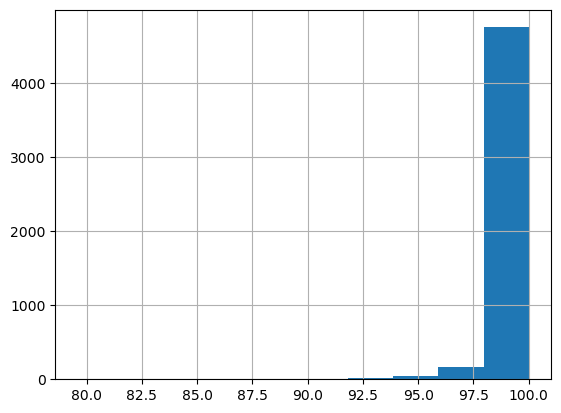

In [124]:
stats_df['pct_majority'].hist()

<Axes: >

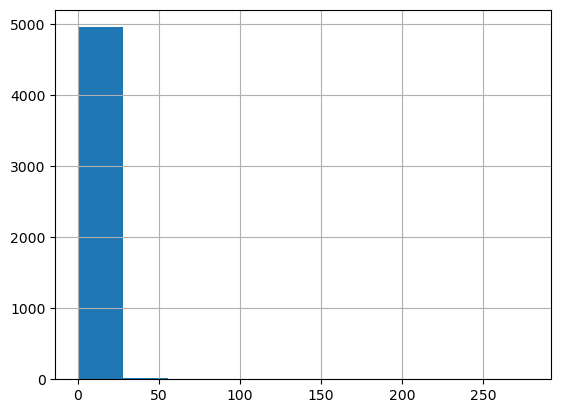

In [98]:
stats_df['roberta'].hist()

<Axes: >

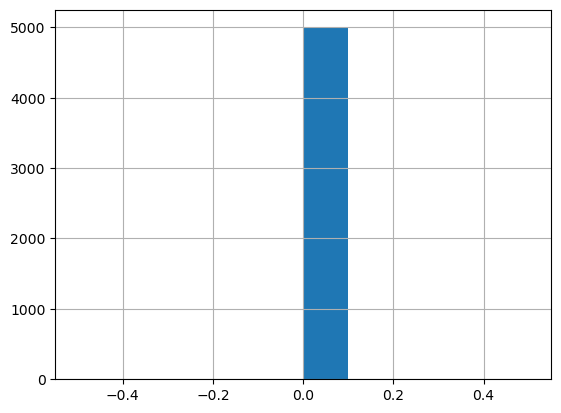

In [99]:
stats_df['scibert'].hist()

<Axes: >

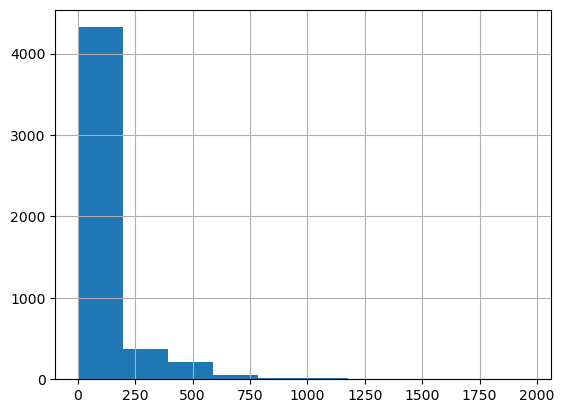

In [100]:
stats_df['deberta'].hist()

<Axes: >

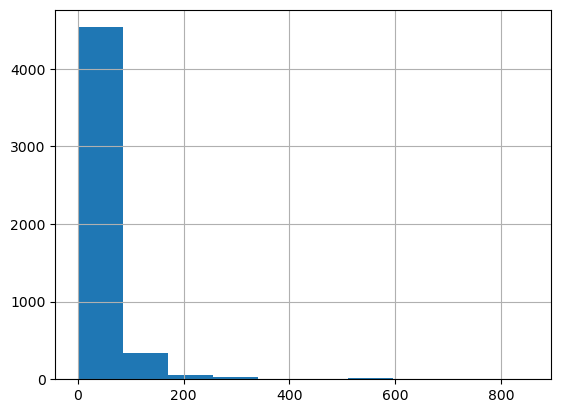

In [101]:
stats_df['biomed_roberta'].hist()

<Axes: >

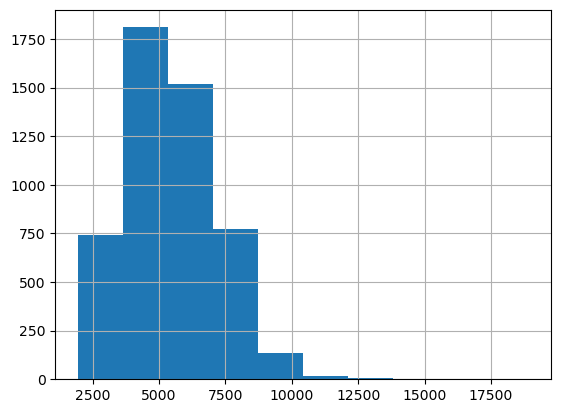

In [102]:
stats_df['all'].hist()

# For local runs

In [ ]:
base_folder = "/Users/gayatri/Documents/Gayatri/US/Self projects/AI Competition/DAGPAP24/data"

In [ ]:
dev_df = pd.read_parquet(base_folder + os.sep + 'dev_data.parquet', engine="fastparquet")
print(dev_df.shape)
dev_df.head()

In [ ]:
dev_df.columns

In [ ]:
merged = dev_df.copy(deep=True)

for model in contesting_models:
    model_df = pd.read_parquet(base_folder + os.sep + f'predictions_{model}.parquet', engine="fastparquet")
    model_df.rename(columns={'preds': f'{model}_preds'}, inplace=True)

    merged = merged.merge(model_df, how='inner', left_index=True, right_index=True)
    print(f"Data shape after merging with {model} model {merged.shape}")

In [ ]:
merged.head()

In [ ]:
%%time
max_pred_df = get_max_repeated_pred(merged)
print(max_pred_df.shape)
max_pred_df.isna().sum()

In [ ]:
0.88/(0.87+0.88+0.89)

In [ ]:
max_pred_df[['preds']].to_parquet(base_folder + os.sep + 'predictions_three_models_combined.parquet') # , engine="fastparquet")

In [ ]:
merged.head()

In [ ]:
merged.to_csv(base_folder + os.sep + 'dev_majority_model_preds.csv')

In [98]:
merged.to_parquet(base_folder + os.sep + 'dev_majority_model_preds.parquet')